In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
df = pd.read_csv('../data/hr_dataset_silver.csv') #type: ignore
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)

In [4]:
def cast_columns(df: pd.DataFrame):
    ordinal_cols = [
        "education",
        "environment_satisfaction",
        "job_involvement",
        "job_level",
        "job_satisfaction",
        "performance_rating",
        "relationship_satisfaction",
        "stock_option_level",
        "work_life_balance"
    ]
    
    for col in ordinal_cols:
        df[col] = df[col].astype(int)
    if df["over_time"].dtype.name == "category":
        df["over_time"] = df["over_time"].map({"Yes": 1, "No": 0})

    return df

def feature_engineering(df:pd.DataFrame):
    df["low_job_satisfaction"] = (df["job_satisfaction"] <= 2).astype(int)
    df["low_env_satisfaction"] = (df["environment_satisfaction"] <= 2).astype(int)
    df["low_work_life_balance"] = (df["work_life_balance"] <= 2).astype(int)
    df["stuck_in_role"] = (df["years_since_last_promotion"] == 0).astype(int)
    df["promotion_ratio"] = df["years_since_last_promotion"] / (df["years_at_company"] + 1)
    df["early_start_ratio"] = df["total_working_years"] / (df["age"] + 1)
    df["income_per_level"] = df["monthly_income"] / (df["job_level"] + 1)
    df["overtime_low_balance"] = ((df["over_time"] == 1) & (df["work_life_balance"] <= 2)).astype(int)
    df["job_hopping_ratio"] = df["num_companies_worked"] / (df["total_working_years"] + 1)
    df["distance_bin"] = pd.cut(
        df["distance_from_home"], 
        bins=[-1, 5, 15, 100], 
        labels=["near", "medium", "far"]
    )
    df["low_sat_low_involvement"] = (
        (df["job_satisfaction"] <= 2) & (df["job_involvement"] <= 2)
    ).astype(int)

    return df

df_features = feature_engineering(cast_columns(df))

In [5]:
def rename_columns(df: pd.DataFrame):
   return df.rename(columns={cols: re.sub(r'(?<!^)(?=[A-Z])|(?<=[a-zA-Z])(?=\d)', '_', cols).lower() for cols in df.columns})

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, recall_score, f1_score,precision_recall_curve
from imblearn.under_sampling import NearMiss



class Models(KNeighborsClassifier, RandomForestClassifier,LogisticRegression):
     ...
RANDOM_STATE = 42
TEST_SIZE = 0.2
SEED = 100

class ModelTrainer:
    def __init__(self, random_state: int = RANDOM_STATE):
        self.random_state = random_state
        self.models_scores = {}

    def get_better_params(self, x_train, y_train):
        best_params = {}
        best_scores = {}
        models = self.define_models()

        params = {
        "KNeighborsClassifier": {"n_neighbors": [3,5,7], "weights": ["uniform","distance"], "metric": ["euclidean","manhattan"]},
        "RandomForestClassifier": {"n_estimators":[50,100], "criterion":["gini","entropy"], "max_depth":[None,5,10]},
        "XGBClassifier": { "max_depth": [3, 4, 5, 6], "learning_rate": [0.01, 0.05, 0.1], "n_estimators": [50, 100, 150], "subsample": [0.6, 0.8, 1.0], "colsample_bytree": [0.6, 0.8, 1.0], "min_child_weight": [1, 3, 5],"scale_pos_weight": [1, 2, 3, 5],},
        "LogisticRegression": {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],'solver': ['liblinear', 'saga'],'penalty': ['l1', 'l2'],'class_weight': ['balanced']},
        }


        for model in models:
          grid_search = GridSearchCV(estimator=[models[model]], param_grid=params[model], n_jobs=-1,cv=5)
          grid_search.fit(x_train, y_train)
          best_scores[model] = grid_search.best_score_
          best_params[model] = grid_search.best_params_

        return best_scores, best_params 

    def define_models(self):
        return {
            "KNeighborsClassifier": KNeighborsClassifier(
                metric='manhattan',
                n_neighbors=3,
                weights='distance'
            ),
            "RandomForestClassifier": RandomForestClassifier(
                criterion='entropy',
                max_depth=5,
                n_estimators=100,
            ),
            "LogisticRegression": LogisticRegression(
               C=1.0,solver='lbfgs',tol=0.0001, class_weight='balanced'
            ),
        }
    
    def prepare_data(self, df: pd.DataFrame):
        text_columns = ['attrition','employee_number']
        x = df.drop(text_columns , axis=1, errors='ignore')
        y = df['attrition'] 
        return x, y
    
    def apply_one_hot_encoder(self, df: pd.DataFrame):
         x,y = self.prepare_data(df)

         categorical_cols = x.select_dtypes(include=['category']).columns.to_list()
         numeric_cols = x.select_dtypes(include=['int64','float64']).columns.to_list()

         transform = ColumnTransformer(
          transformers=[
            ('onehot', OneHotEncoder(drop='first', sparse_output=False), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
          ]
         )
         x_transformed = transform.fit_transform(x)

         ohe_change_names = transform.named_transformers_['onehot'].get_feature_names_out(categorical_cols)

         final_names = list(ohe_change_names) + numeric_cols

         x_final = pd.DataFrame(x_transformed, columns=final_names, index=x.index) #type: ignore

         return rename_columns(x_final), y
    
    def fit_and_score(self, models:dict[str,Models], x_train, x_test,y_train,y_test): 
         models_scores = {}
         for name, model in models.items():
                model.fit(x_train,y_train)
                models_scores[name] = model.score(x_test, y_test)
         return models_scores
    

    def get_predictions(self,models:dict[str,Models], x_test):
         
        predict_df = pd.DataFrame([])
        for name, model in models.items():
             predict_df[name] = model.predict(x_test)
        return predict_df
    
    def confusion_matrix_evaluation(self, models,y_test,y_pred):
        evaluation_models = {}
        for name, _ in models.items():
             cn = confusion_matrix(y_test, y_pred[name])
             true_negative,false_positive , false_negative, true_positive  = cn.ravel()
             evaluation_models[name] = pd.DataFrame([[true_negative, false_positive],
                                                    [false_negative, true_positive]],
                                                     index=["Real Negativo", "Real Positivo"],
                                                     columns=["Previsto Negativo", "Previsto Positivo"]
                                                    )
        return evaluation_models
    def data_balance(self, x, y, method='smote'):
        if method == 'under': 
            nm = NearMiss()
            result_x, result_y = nm.fit_resample(x, y) # type: ignore
            return result_x, result_y   # agora consistente
        
        smote_balance = SMOTE(random_state=SEED)
        result_x, result_y = smote_balance.fit_resample(x, y) #type: ignore
        return result_x, result_y

In [7]:
trainer = ModelTrainer()

models = trainer.define_models()

x, y =trainer.apply_one_hot_encoder(df_features)

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

x_trainb, y_trainb = trainer.data_balance(x_train, y_train, 'under')

models_score = trainer.fit_and_score(
    models=models,
    x_train=x_trainb,
    x_test=x_test,
    y_train=y_trainb,
    y_test=y_test
)

### K FOLD VALIDATION RECALL

In [17]:
scorers = {
    'accuracy': 'accuracy',
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1)
}

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

results = cross_validate(models['RandomForestClassifier'], x_trainb, y_trainb, cv=kfold, scoring=scorers)
print(results['test_accuracy'].mean(), results['test_recall'].mean(), results['test_f1'].mean())

results = cross_validate(models['LogisticRegression'], x_trainb, y_trainb, cv=kfold, scoring=scorers)
print(results['test_accuracy'].mean(), results['test_recall'].mean(), results['test_f1'].mean())

results = cross_validate(models['KNeighborsClassifier'], x_trainb, y_trainb, cv=kfold, scoring=scorers)
print(results['test_accuracy'].mean(), results['test_recall'].mean(), results['test_f1'].mean())


0.7498717948717948 0.7085666289260312 0.7396571101093301
0.7522435897435897 0.7483522832890176 0.7451070156203018
0.648974358974359 0.4743637944741727 0.5699094087898942


In [10]:
# best_scores, best_params = trainer.get_better_params(x_train=x_trainb, y_train=y_trainb)
# for model_name, params in best_params.items():
#     print(f"# Melhores parâmetros para {model_name}")
#     print(f"{model_name} = {model_name}(**{params})\n")

In [11]:
y_pred = trainer.get_predictions(models, x_test)

### Avaliando modelos

In [12]:
for model in models:
    print(model + ':')
    print(classification_report(y_test, y_pred[model], target_names=['Negativo', 'Positivo']))

KNeighborsClassifier:
              precision    recall  f1-score   support

    Negativo       0.90      0.71      0.79       255
    Positivo       0.20      0.46      0.27        39

    accuracy                           0.68       294
   macro avg       0.55      0.59      0.53       294
weighted avg       0.80      0.68      0.72       294

RandomForestClassifier:
              precision    recall  f1-score   support

    Negativo       0.89      0.47      0.61       255
    Positivo       0.16      0.64      0.25        39

    accuracy                           0.49       294
   macro avg       0.53      0.55      0.43       294
weighted avg       0.80      0.49      0.57       294

LogisticRegression:
              precision    recall  f1-score   support

    Negativo       0.92      0.52      0.67       255
    Positivo       0.19      0.72      0.30        39

    accuracy                           0.55       294
   macro avg       0.56      0.62      0.48       294
weighted

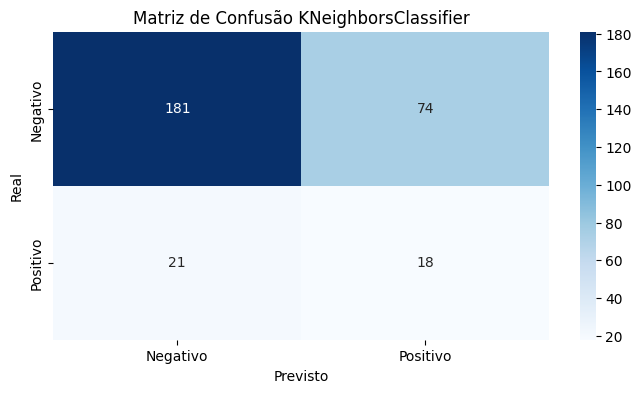

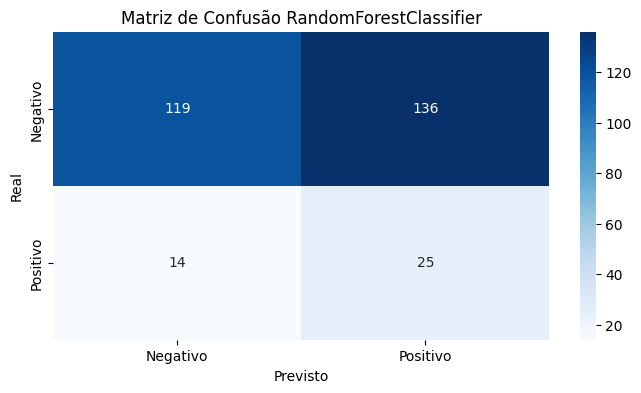

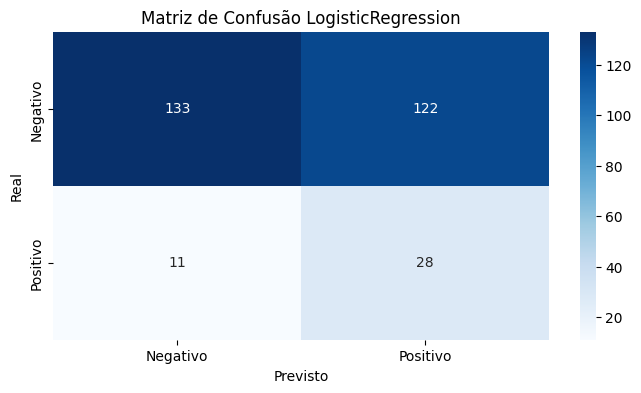

In [13]:
matrix_models = trainer.confusion_matrix_evaluation(models, y_test, y_pred)

for model in matrix_models:
    labels = ['Negativo', 'Positivo']
    plt.figure(figsize=(8,4))
    sns.heatmap(matrix_models[model], annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Real')
    plt.xlabel('Previsto')
    plt.title('Matriz de Confusão ' + model)
    plt.show()


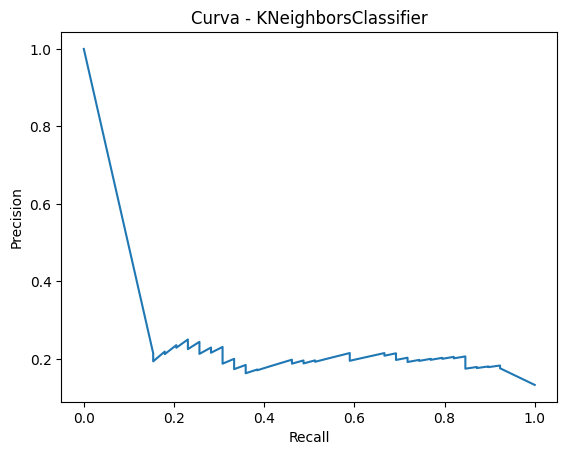

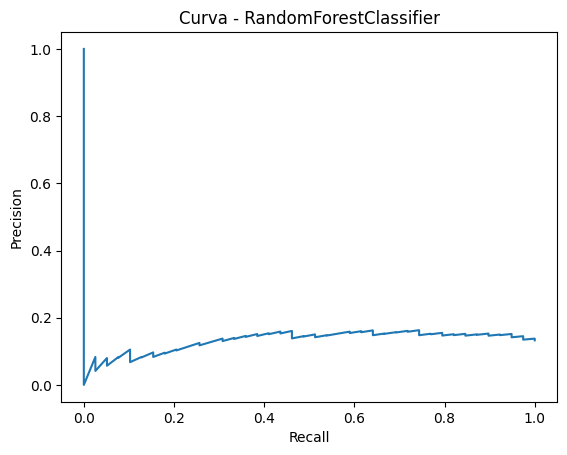

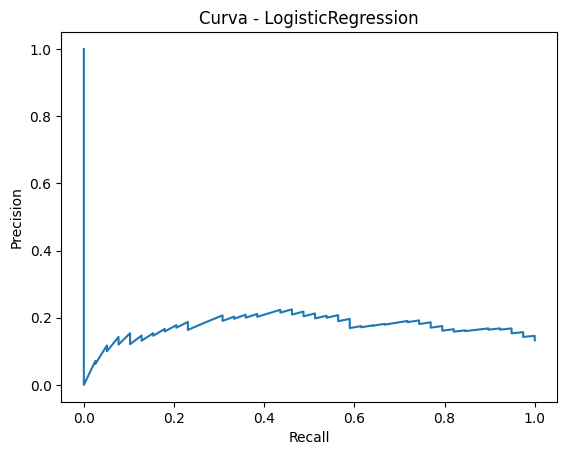

In [14]:
for model in models:
    probs = models[model].predict_proba(x_test)[:,1]
    prec, rec, thr = precision_recall_curve(y_test, probs)
    plt.title("Curva - " + model )
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()